# 1D time domain EM inversion 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG.electromagnetics import resistivity as dc
from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

from pymatsolver import Pardiso

## create a model 

In [2]:
rho_back = 100
sigma_layer = 0.1
layer_depth = np.r_[120, 160]

sigma_true = np.r_[1./rho_back, sigma_layer, 1./rho_back]
m_true = np.log(sigma_true)
layer_thicknesses_true = np.r_[layer_depth[0], np.diff(layer_depth)]

In [5]:
sigma_true

array([0.01, 0.1 , 0.01])

(400.0, 0.0)

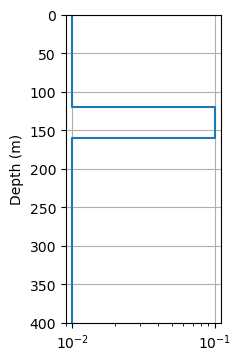

In [4]:
fig, ax = plt.subplots(1,1, figsize=(2, 4))
plot_1d_layer_model(layer_thicknesses_true, sigma_true, ax=ax, label="True")
ax.grid()
ax.set_ylim(np.r_[400, 0])

## set up a survey

In [7]:
tx_radius = 10
rx_times = np.logspace(-4, -2, 20)

print(f"times: {rx_times.min()*1e3:1.0e}ms, {rx_times.max()*1e3:1.0e}ms")

times: 1e-01ms, 1e+01ms


In [8]:
rx_z = tdem.receivers.PointMagneticFluxTimeDerivative(
    np.r_[0, 0, 0], times=rx_times, orientation="z"
)

src = tdem.sources.CircularLoop(
    location=np.r_[0, 0, 0], radius=tx_radius, 
    receiver_list=[rx_z], #waveform=waveform
)

survey = tdem.Survey([src])

## create synthetic data

In [10]:
sim1d_true = tdem.Simulation1DLayered(
    survey=survey, 
    thicknesses=layer_thicknesses_true, 
    sigmaMap=maps.ExpMap(nP=3)
)
dobs = sim1d_true.dpred(m_true)

Text(0, 0.5, 'db/dt (V)')

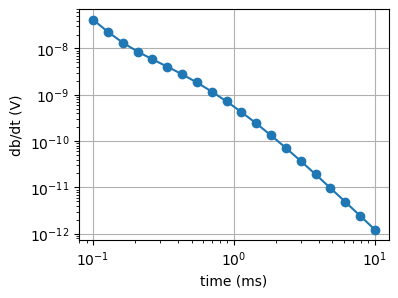

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
                       
ax.loglog(rx_times*1e3, -dobs, "-o")
ax.grid()
ax.set_xlabel("time (ms)")
ax.set_ylabel("db/dt (V)")

## set up the inversion

In [14]:
data_invert = data.Data(survey, dobs=dobs, relative_error=0.05)
data_invert[src, rx_z]

array([-4.19775479e-08, -2.28768285e-08, -1.34206897e-08, -8.58307648e-09,
       -5.84240195e-09, -4.05869298e-09, -2.78115802e-09, -1.84546850e-09,
       -1.17746790e-09, -7.21488363e-10, -4.25219358e-10, -2.41756370e-10,
       -1.33102329e-10, -7.12784054e-11, -3.73058044e-11, -1.91772355e-11,
       -9.72971300e-12, -4.89448216e-12, -2.45125561e-12, -1.22645642e-12])

### create inversion mesh & simulation

In [17]:
cs_invert = 5
inv_thicknesses = np.hstack([[cs_invert]*int(300/cs_invert), cs_invert * np.logspace(0, 1.5, 20)])

In [18]:
mesh = discretize.TensorMesh([(np.r_[inv_thicknesses, inv_thicknesses[-1]])], origin="0")
mesh

TensorMesh: 81 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     81          0.00      1,384.28      5.00    158.11    1.20

In [19]:
sim1d = tdem.Simulation1DLayered(
    survey=survey, thicknesses=inv_thicknesses, sigmaMap=maps.ExpMap(mesh)
)

In [20]:
def setup_inversion(norms=[0, 0]): 
    dmis = data_misfit.L2DataMisfit(simulation=sim1d, data=data_invert)
    reg = regularization.Sparse(
        mesh, alpha_s=0.1, alpha_x=1.0, 
        reference_model=np.log(1./rho_back),
        norms=norms
    )

    opt = optimization.InexactGaussNewton(maxIter=30)
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
    
    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

    # Options for outputting recovered models and predicted data for each beta.
    save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

    # Directives for the IRLS
    update_IRLS = directives.Update_IRLS(
        max_irls_iterations=10, minGNiter=1, coolEpsFact=1.5, update_beta=True
    )

    # Updating the preconditionner if it is model dependent.
    update_jacobi = directives.UpdatePreconditioner()

    # Add sensitivity weights
    sensitivity_weights = directives.UpdateSensitivityWeights()

    # The directives are defined as a list.
    directives_list = [
        sensitivity_weights,
        starting_beta,
        save_iteration,
        update_IRLS,
        update_jacobi,
    ]
    
    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)
    
    return inv

In [21]:
invl2 = setup_inversion([2, 2])
starting_model = np.log(1./rho_back)*np.ones(mesh.n_cells)

recovered_model_l2 = invl2.run(starting_model)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.05e+03  1.34e+03  0.00e+00  1.34e+03    2.15e+02      0              
   1  1.52e+03  1.17e+03  2.73e-02  1.21e+03    1.07e+02      0              
   2  7.62e+02  1.01e+03  1.10e-01  1.10e+03    1.05e+02      0   Skip BFGS  
   3  3.81e+02  7.70e+02  4.08e-01  9.26e+02    1.03e+02      0              
   4  1.91e+02  4.81e+02  1.26e+00  7.21e+02    9.22e+01      0              
   5  9.53e+01  2.57e+02  2.85e+00  5.28e+02    7.44e+01      0   Skip BFGS  
   6  4.76e+01  1.26e+02  5.18e+0

In [22]:
invl1 = setup_inversion([1, 1])
recovered_model_l1 = invl1.run(starting_model)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.58e+03  1.34e+03  0.00e+00  1.34e+03    2.15e+02      0              
   1  1.29e+03  1.23e+03  1.51e-02  1.25e+03    1.39e+02      0              
   2  6.45e+02  9.54e+02  1.63e-01  1.06e+03    1.03e+02      0   Skip BFGS  
   3  3.23e+02  7.03e+02  5.42e-01  8.78e+02    1.02e+02      0   Skip BFGS  
   4  1.61e+02  4.16e+02  1.57e+00  6.69e+02    8.81e+01      0              
   5  8.07e+01  2.15e+02  3.39e+00  4.88e+02    6.74e+01      0   Skip BFGS  
   6  4.03e+01  1.07e+02  5.77e+0

In [23]:
invl0 = setup_inversion([0, 0])
recovered_model_l0 = invl0.run(starting_model)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.65e+03  1.34e+03  0.00e+00  1.34e+03    2.15e+02      0              
   1  1.33e+03  1.17e+03  3.42e-02  1.22e+03    1.11e+02      0              
   2  6.63e+02  9.66e+02  1.51e-01  1.07e+03    1.03e+02      0   Skip BFGS  
   3  3.32e+02  7.14e+02  5.18e-01  8.86e+02    1.02e+02      0   Skip BFGS  
   4  1.66e+02  4.26e+02  1.51e+00  6.77e+02    8.88e+01      0              
   5  8.29e+01  2.21e+02  3.31e+00  4.95e+02    6.82e+01      0   Skip BFGS  
   6  4.14e+01  1.10e+02  5.67e+0

Text(0, 0.5, 'db/dt')

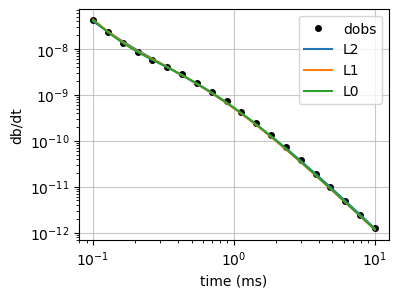

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

ax.loglog(rx_times*1e3, -dobs, "ko", label="dobs", ms=4)
ax.loglog(rx_times*1e3, -sim1d.dpred(recovered_model_l2), label="L2")
ax.loglog(rx_times*1e3, -sim1d.dpred(recovered_model_l1), label="L1")
ax.loglog(rx_times*1e3, -sim1d.dpred(recovered_model_l0), label="L0")

ax.legend()
ax.grid("both", alpha=0.7)
ax.set_xlabel("time (ms)")
ax.set_ylabel("db/dt")

Text(0.5, 0, 'conductivity (S/m)')

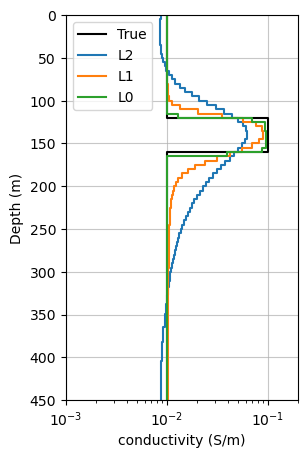

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(3, 5))

plot_1d_layer_model(sim1d_true.thicknesses, np.exp(m_true), ax=ax, color="k", label="True")
plot_1d_layer_model(mesh.h[0], np.exp(recovered_model_l2), ax=ax, label="L2")
plot_1d_layer_model(mesh.h[0], np.exp(recovered_model_l1), ax=ax, label="L1")
plot_1d_layer_model(mesh.h[0], np.exp(recovered_model_l0), ax=ax, label="L0")

ax.set_ylim([450, 0])
ax.set_xlim([1e-3, 2e-1])
ax.grid("both", alpha=0.7)
ax.legend()

ax.set_xlabel("conductivity (S/m)")